In [1]:
import torch
import torch.nn as nn
import tiktoken

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from utils.gpt import GPTModel

#### LLM generating text
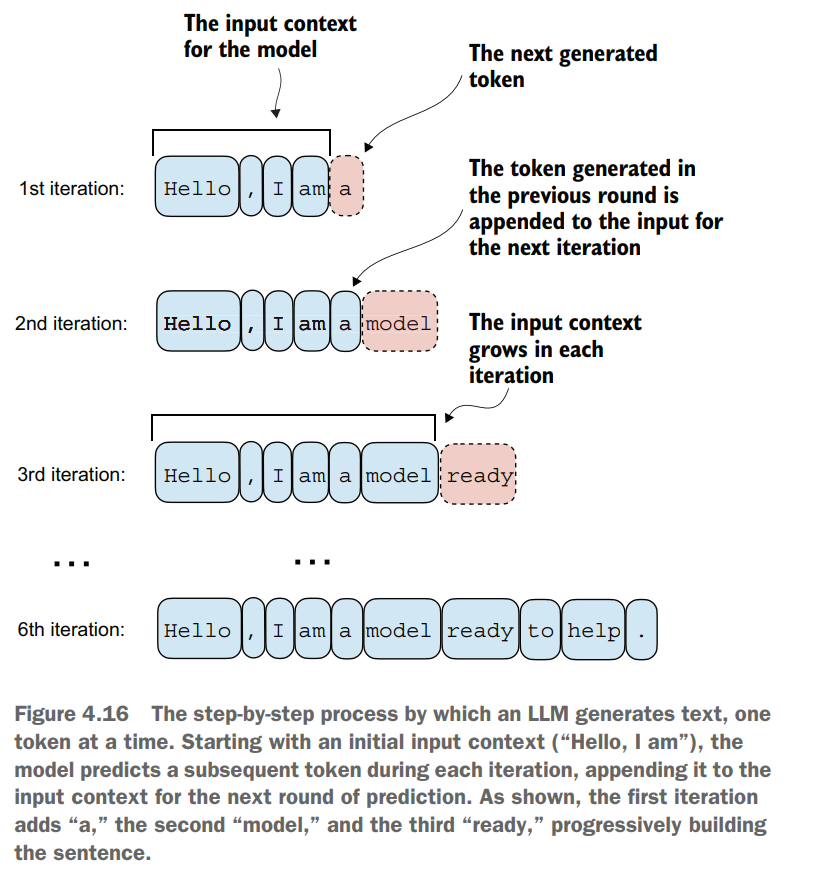

The process can be summarized as:

1. The model generates one token.
2. That token is appended to the input.
3. The updated input is fed back into the model for the next iteration.

But until now the `forward` method we coded in the `GPTModel` does not implement this iterative token-by-token generation. 

Instead, it processes the entire input sequence in a single forward pass and produces logits for all tokens in the sequence.

Our code is right now setup for **training** not **generation**

In [3]:
GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 1024, # Context length
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}


tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [15]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)

print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.0072, -0.2137, -0.3467,  ..., -0.3240, -0.2338, -0.1070],
         [ 0.7063, -0.7429, -0.6645,  ..., -0.6530, -0.1393, -0.2166],
         [ 0.8226, -0.2982, -0.4547,  ...,  0.0913, -0.6949, -0.2091],
         [-0.3933,  0.3074, -0.1343,  ...,  1.0464,  0.4620, -0.5298]],

        [[ 0.1386, -0.4081, -0.1563,  ..., -0.0892, -0.0672, -0.0157],
         [ 0.2353, -0.1177, -0.1307,  ...,  1.0729, -0.3517,  0.3905],
         [ 0.7367,  0.3377, -0.4311,  ...,  0.8471,  0.2219, -0.2541],
         [ 0.0166, -0.0721,  0.3451,  ...,  1.1352, -0.4069,  0.0309]]],
       grad_fn=<UnsafeViewBackward0>)


### Next-token generation Process

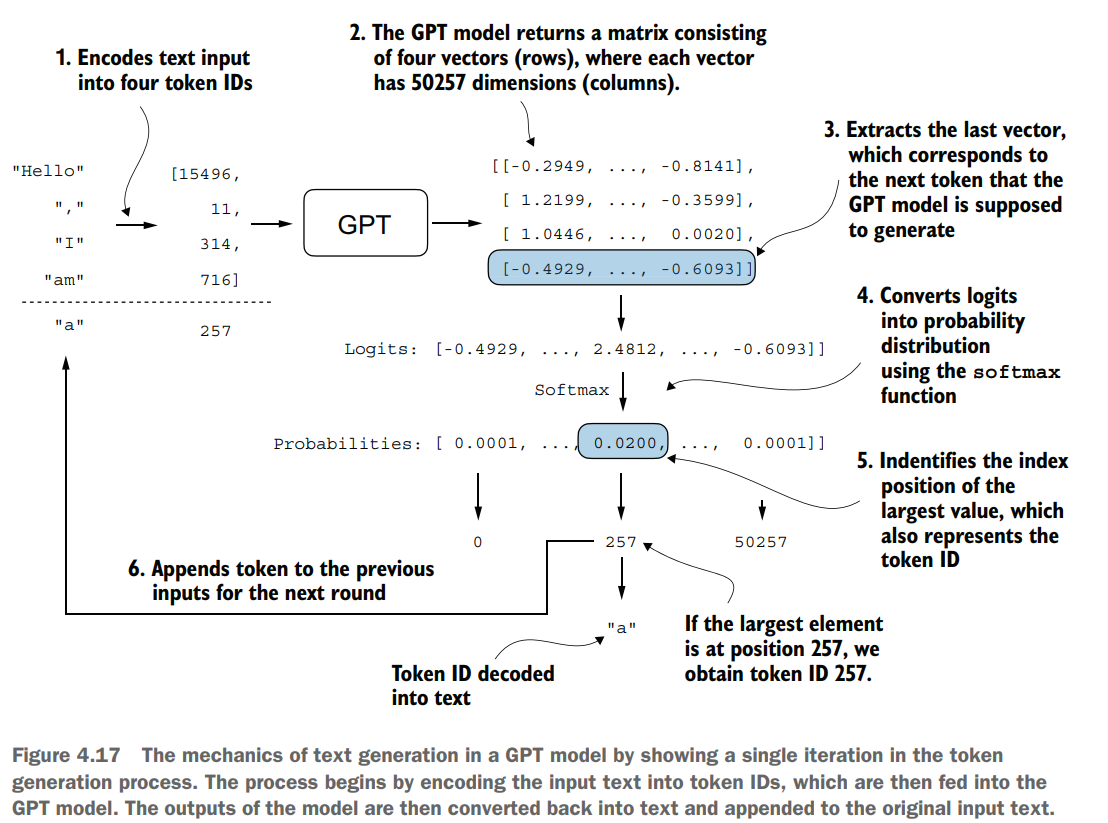

The entire process is summarized in the following steps:

#### Step 1: Input to the Model:

    The GPT model takes an input sequence of tokens (e.g., words or subwords) and generates the next token in the sequence.

    At each step, the model processes the input to predict the next token.

#### Step 2: Model Output:

    The model outputs a matrix where each row is a vector representing potential next tokens. Each vector contains scores (logits) for every possible token in the vocabulary.

#### Step 3: Softmax Conversion:

    The vector corresponding to the next token (the last vector) is extracted and passed through the softmax function (all logits must sum to 1 for representing probability), which converts the raw scores (logits) into a probability distribution. This distribution assigns a probability to each possible token in the vocabulary.

#### Step 4: Selecting the Next Token:

    The token with the highest probability is identified by finding the index of the maximum value in the probability distribution. This index corresponds to the token ID of the predicted token.

#### Step 5: Decoding the Token:

    The token ID is mapped back to its corresponding text (e.g., a word or subword) using the model's vocabulary. This produces the next token in the sequence.

#### Step 6: Updating the Input:

    The newly generated token is appended to the previous input sequence, creating a new input sequence for the next iteration of the process.

#### Step 7: Iterative Text Generation:

    This step-by-step process is repeated, allowing the model to generate text sequentially. By building on the initial input context, the model produces coherent phrases and sentences.


### Function implementing text generation

In [5]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    """
    Generate text iteratively using the model until:
    number of iterations = max_new_tokens.
    """
    # Here, model is an instance of GPTModel. 
    # idx is the input text tokenized and converted to tensor
    # and max_new_tokens is the number of tokens to generate.
    # and context_size is the size of the context window (how many tokens model has to process).

    # idx example:
    # tensor([[6109, 3626, 6100,  345],
        # [6109, 1110, 6622,  257]])
    
    # idx shape = (batch, n_tokens)
    
    for _ in range(max_new_tokens):

        '''
        Crops current context if it exceeds the supported context size, 
        e.g., if LLM supports only 5 tokens, and the context size is 10, 
        then only the last 5 tokens are used as context 
        '''
        idx_cond = idx[:, -context_size:]
        # idx_cond is the last context_size tokens of idx
        # idx_cond example:
        '''
        idx = tensor([[10, 23, 45, 67, 89, 123, 56, 78], # First sequence/batch
                    [9, 8, 7, 6, 5, 4, 3, 2]]) # Second sequence/batch
        
        If context_size = 6 then:
        idx_cond = tensor([[45, 67, 89, 123, 56, 78], # First sequence/batch
                           [6, 5, 4, 3, 2]])
        '''

        # Pass the current input to the model and get the logits
        with torch.no_grad(): 
            # No need to compute gradients for inference
            logits = model(idx_cond)
        
        # The shape of logits is (batch_size, context_size, vocab_size)
        # Each logit vector represents scores for all possible tokens in the vocabulary for each position in the input sequence.
        
        # Now, we extract the logits for the last position of each sequence
        # This is because, in autoregressive generation, we’re only interested in predicting the next token after the current sequence.
        # So, (batch_size, context_size, vocab_size) -> (batch_size, vocab_size)
        logits = logits[:, -1, :]

        # Applying softmax to get the probabilities of the next token
        probabs = torch.softmax(logits, dim = -1)  # (batch_size, vocab_size)

        # Get the index of the next token with the highest probability for each batch
        idx_next = torch.argmax(probabs, dim = -1, keepdim=True) # (batch_size, 1)

        # Append the predicted token to the input sequence

        idx = torch.cat((idx, idx_next), dim = 1) # (batch_size, n_tokens + 1)

    return idx

    

The softmax function is monotonic, meaning it preserves the order of its inputs when transformed into outputs.

So, in practice, the softmax step is redundant since the position with the highest score in the softmax output tensor is the same position in the logit tensor. In other words, we could apply the `torch.argmax` function to the logits tensor directly and get identical results. 

But, here it was included to illustrate the full process to add intuition.

In the next chapter, we will use additional sampling techniques to modify the softmax outputs such that the model doesn’t always select the most likely token. This introduces variability and creativity in the generated text. 

#### Note:
The function generates tokens **for each batch (sequence) in parallel**

This means that the generation process is parallelized across the batch. For example, if batch_size = 2, the function generates one new token for both sequences in each iteration, not one sequence at a time.

The function does not assume that each sequence is a complete sentence; it simply treats each row of idx as an independent sequence of tokens. These sequences could represent sentences, sentence fragments, or any tokenized text.

##### Grok 3's answer when asked about if you convert my query into batches as well:

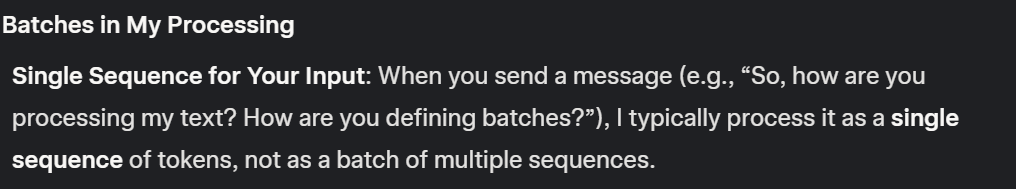

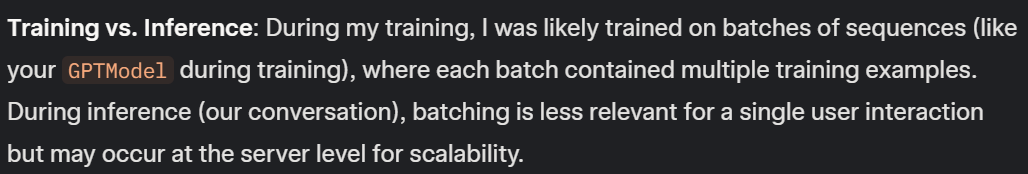
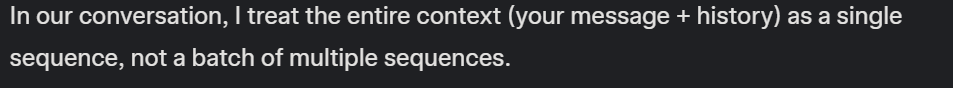

Let's use the function now

In [16]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded: ", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension
print("encoded_tensor: ", encoded_tensor)
print("encoded_tensor shape: ", encoded_tensor.shape)

encoded:  [15496, 11, 314, 716]
encoded_tensor:  tensor([[15496,    11,   314,   716]])
encoded_tensor shape:  torch.Size([1, 4])


In [19]:
# For inference, we need to set the model to evaluation mode
model.eval()
# In evaluation mode, dropout layers are disabled and the model behaves deterministically.
# Also, batch normalization layers use running statistics(computed during training) instead of batch statistics.
# ensuring consistent normalization regardless of the input batch size.

# Also, weights are not updated during evaluation.

out = generate_text_simple(model, 
                           encoded_tensor, 
                           max_new_tokens=10, 
                           context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018,  7283, 46275, 41426, 33167, 33239,
          1946, 25644, 17816, 13745]])
Output length: 14


Using the .decode method of the tokenizer, we can convert the IDs back into text:

In [21]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Feature IT snowballProtect youngstersMu 2014440[' Original


As we can see, the model generated gibberish, which is not at all like the coherent text.
The reason the model is unable to produce coherent text is that we haven’t trained it yet. So far, we have only implemented the GPT architecture and initialized a GPT model instance with initial random weights.